In [45]:
from examples.seismic import Model, ModelViscoacoustic, plot_velocity
from devito import *
from utils import *
import sympy as sp
import numpy as np
import matplotlib as plt
%matplotlib inline
from IPython.display import clear_output
import gc

nx = 738
nz = 240
nbl = 85
space_order = 8
dtype = np.float32
shape = (nx, nz)
spacing = (12.5, 12.5)
origin = (0., 0.)



v = np.empty(shape, dtype=dtype)


path = "marmousi-resample-738x240.bin"
a = open(path)
v = np.fromfile(a, dtype=dtype).reshape([nx, nz])
v=v/1000

qp = np.zeros(shape)
qp[:] = 3.516*((v[:]*1000.)**2.2)*10**(-6) 

rho = np.zeros(shape)
rho[:] = 0.31*(v[:]*1000.)**0.25 

In [46]:
model = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, b=1/rho,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)


Operator `initdamp` ran in 0.01 s


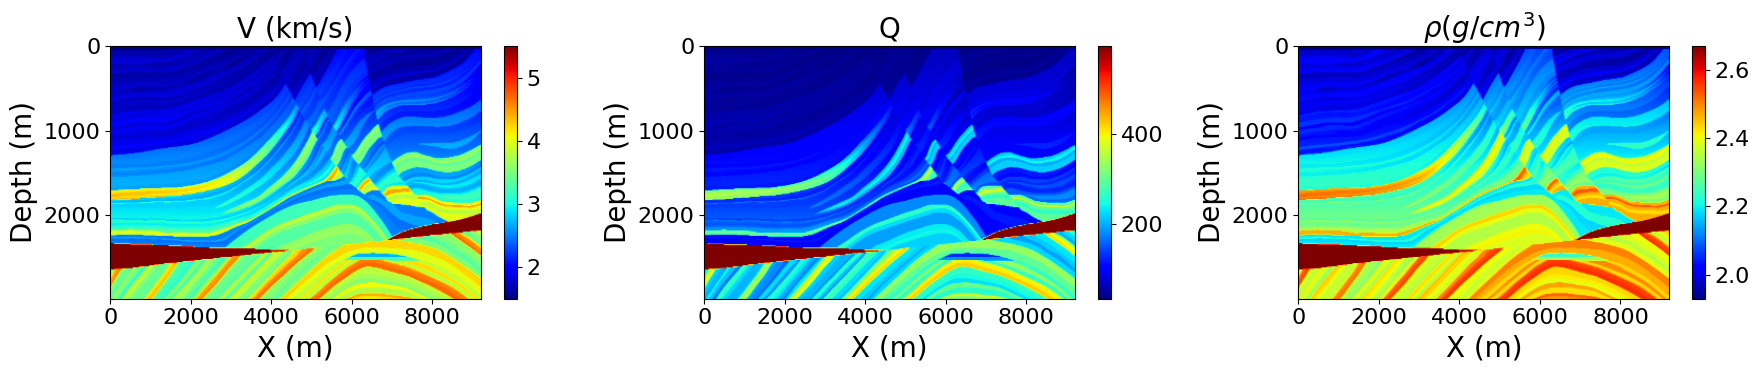

In [47]:
V_Q_plot(model)

In [48]:
model0 = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, b=1/rho,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)
filter_sigma = (6, 6)
gaussian_smooth(model0.vp, sigma=filter_sigma)
gaussian_smooth(model0.qp, sigma=filter_sigma)
gaussian_smooth(model0.b, sigma=filter_sigma)

Operator `initdamp` ran in 0.01 s


b(x, y)

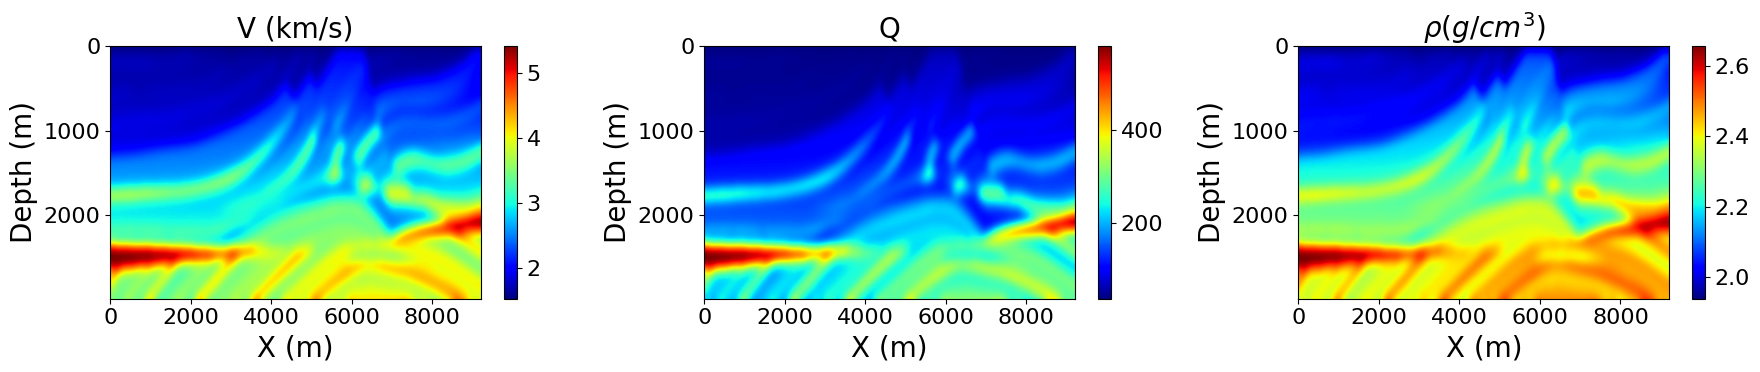

In [49]:
V_Q_plot(model0)

In [50]:
from examples.seismic import TimeAxis

t0 = 0. 
tn = 5000.
#dt = 0.0008
dt = model.critical_dt
time_range = TimeAxis(start = t0, stop = tn, step = dt)



In [51]:
from examples.seismic import RickerSource

f0 = 0.030
src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 1.


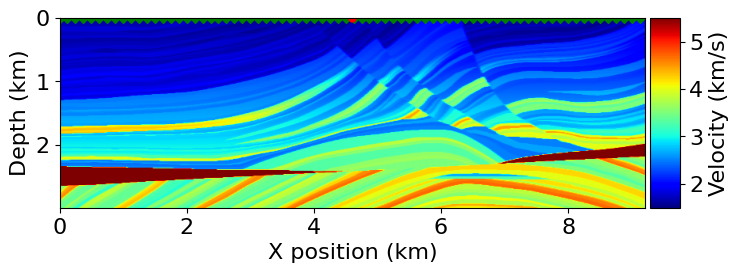

In [52]:
from examples.seismic import Receiver

rec_coordinates = np.empty((model.shape[0], 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
rec_coordinates[:, 1] = 1.

plot_velocity(model, source=src.coordinates.data,receiver=rec_coordinates[::10,:])

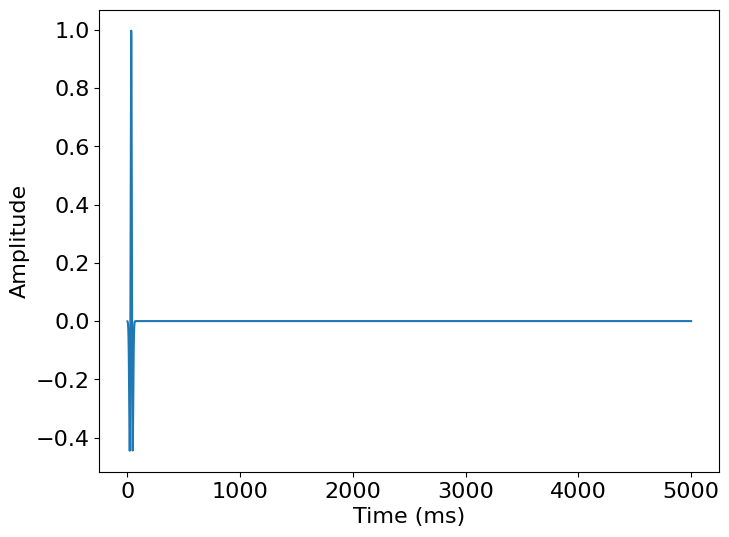

In [53]:
from examples.seismic import AcquisitionGeometry

geometry = AcquisitionGeometry(model, rec_coordinates, src.coordinates.data, t0, tn, f0=f0, src_type='Ricker')
geometry.src.show()

In [54]:
from examples.seismic.viscoacoustic import ViscoacousticWaveSolver
from examples.seismic.plot_model_mod import plot_shotrecord

solver = ViscoacousticWaveSolver(model, geometry, space_order=space_order, kernel='kv')
d0 = solver.forward(vp=model.vp, qp=model.qp, b=model.b, dt=dt)[0]

Operator `Forward` ran in 8.80 s


In [55]:
d1 = solver.forward(vp=model0.vp, qp=model0.qp, b=model0.b, dt=dt)[0]

Operator `Forward` ran in 8.19 s


Clipping low values below -0.04982 and high values above 0.04859.


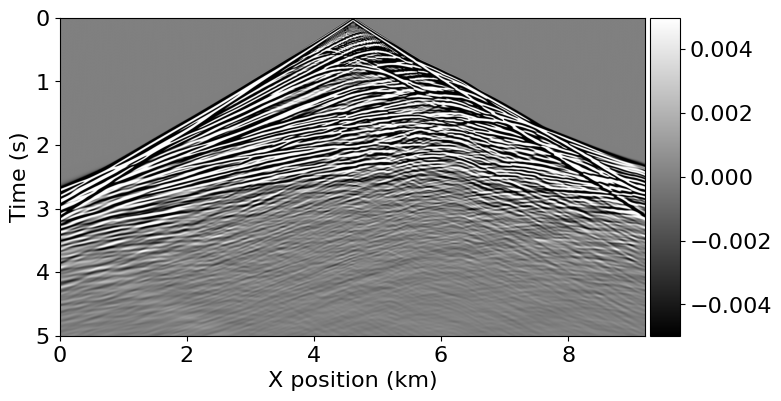

In [56]:
plot_shotrecord(d0.data , model, t0, tn,clip_percent=99,clip_low=1)

Clipping low values below -0.04059 and high values above 0.02481.


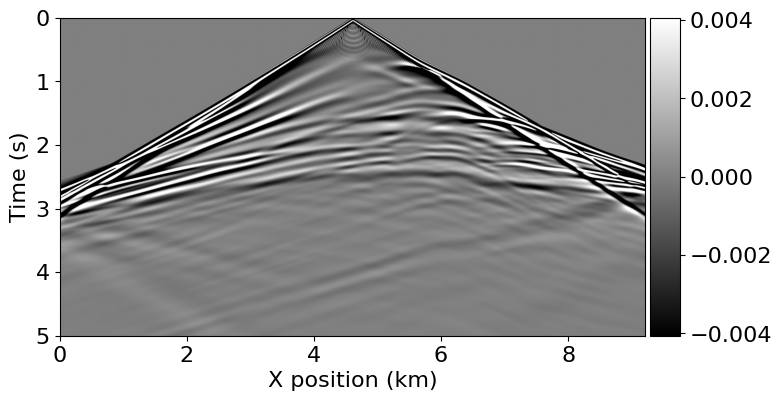

In [57]:
plot_shotrecord(d1.data , model, t0, tn,clip_percent=99,clip_low=1)

In [58]:
d1.data.tofile('smooth.bin')

Clipping low values below -0.05626 and high values above 0.04886.


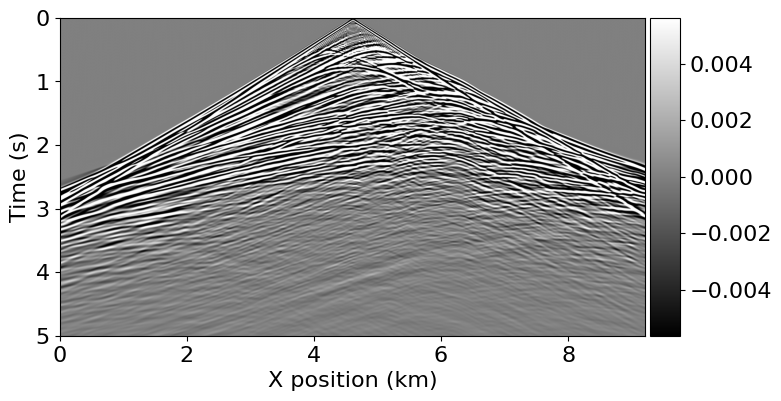

In [59]:
plot_shotrecord(d1.data-d0.data , model, t0, tn,clip_percent=99,clip_low=1)

In [60]:
# Prepare the varying source locations
nshots = 151
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(10., model.domain_size[0], num=nshots)
source_locations[:, 1] = 5.

print(int(time_range.num))
#Gerando o dado SLS
d0 = np.empty((nshots, int(time_range.num), shape[0]), dtype=np.float32)

for i in range(nshots):
    print('Shot source %d out of %d' % (i+1, nshots))
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    d = solver.forward(vp=model.vp, qp=model.qp, b=model.b, dt=dt)[0]
    d0[i] = d.data[:]
    
    clear_output(wait=True)
gc.collect()

9046

In [61]:
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource
from IPython.display import clear_output
from examples.seismic.viscoacoustic.operators import sls_2nd_order, kv_2nd_order, maxwell_2nd_order
from utils import acoustic_2nd_order, image_show, modelling

kernels = {'sls2': sls_2nd_order,'kv2': kv_2nd_order, 'max2': maxwell_2nd_order, 'acoustic2':acoustic_2nd_order}

def ImagingOperator(model, model0, image, dt, kernel="kv2"):
    
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order, staggered=NODE)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=space_order, 
                     save=time_range.num, staggered=NODE)
    
   
    eq_kernel = kernels[kernel]
    eqn = eq_kernel(model, geometry, v, forward=False)
    
    d0 = PointSource(name='d0', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)   
    
    res_term = d0.inject(field=v.backward, expr=d0 * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)
    
    return Operator([eqn] + res_term + [image_update],
                    subs=model.spacing_map)


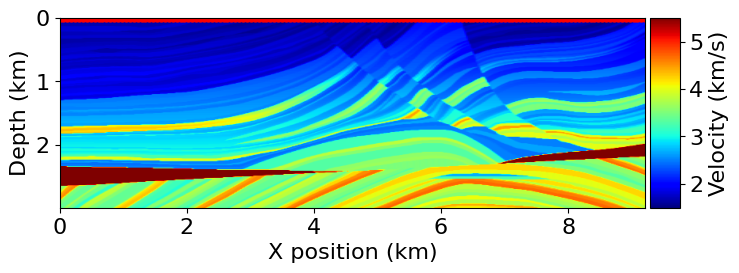

In [62]:
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.domain_size[0], num=nshots)
source_locations[:, 1] = 1

plot_velocity(model, source=source_locations)

In [63]:
from devito import Function

def rtm (kernel, dt):
    # Create image symbol and instantiate the previously defined imaging operator
    image = Function(name='image', grid=model.grid, space_order = space_order)
    op_imaging = ImagingOperator(model, model0, image, dt, kernel=kernel) 

    for i in range(nshots):
        print('Imaging %s for source %d out of %d' % (kernel, i+1, nshots))

        # Compute smooth data and full forward wavefield u0
        _, u0  = modelling(model0, time_range, f0, dt, sl=source_locations[i, :], kernel=kernel, time_order=2)  

        # Compute gradient from the data residual  
        v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)
        
        if kernel!= "acoustic2":
            op_imaging(u=u0, v=v, vp=model0.vp, b=model0.b, qp=model0.qp, dt = dt, d0=d0[i])
        else :
            op_imaging(u=u0, v=v, vp=model0.vp, b=model0.b, dt =dt, d0=d0[i])
            
        clear_output(wait=True)
    return image

In [64]:
#Acústica
kernel='acoustic2'
data1 = rtm(kernel, dt)

#Modelo SLS
kernel='max2'
data2 = rtm(kernel, dt)

#Modelo Kelvin-Voigt
kernel='kv2'
data3 = rtm(kernel, dt)

#Modelo Maxwell
kernel='sls2'
data4 = rtm (kernel, dt)

Imaging sls2 for source 151 out of 151


Operator `Kernel` ran in 5.84 s
Operator `Kernel` ran in 15.60 s


Original data shape: (908, 409)
Clipping low values below -4837.98535 and high values above 19138.88086.


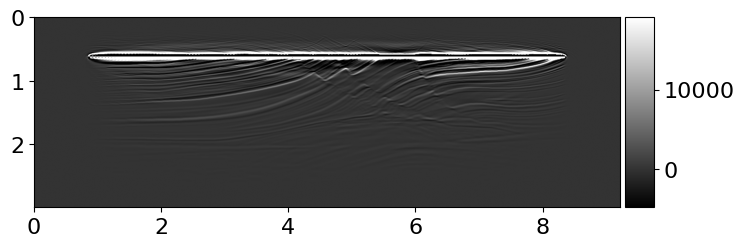

In [65]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(data1.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (908, 409)
Clipping low values below -2210.84277 and high values above 7265.75977.


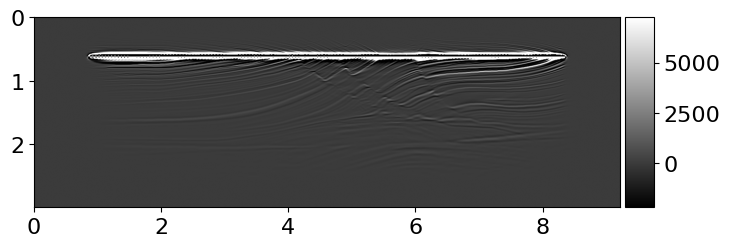

In [66]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(data2.data, axis=1),model,clip_percent=98,clip_low=2)

Original data shape: (908, 409)
Clipping low values below -3849.25806 and high values above 15325.31250.


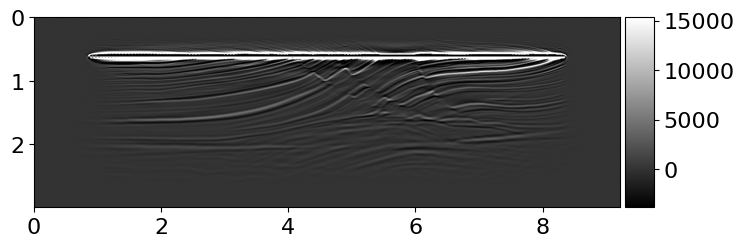

In [67]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(data3.data, axis=1),model,clip_percent=98,clip_low=2)

Original data shape: (908, 409)
Clipping low values below -3352.23584 and high values above 11711.07910.


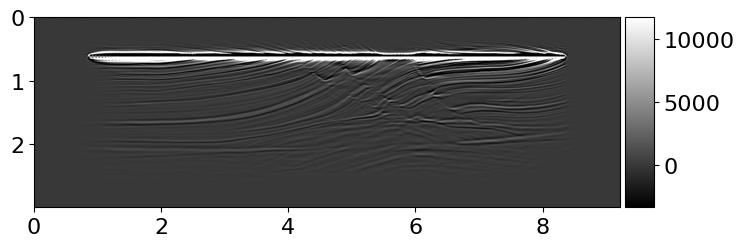

In [68]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(data4.data, axis=1),model,clip_percent=98,clip_low=2)

Original data shape: (738, 239)
Clipping low values below -5193.81006 and high values above 52565.22656.


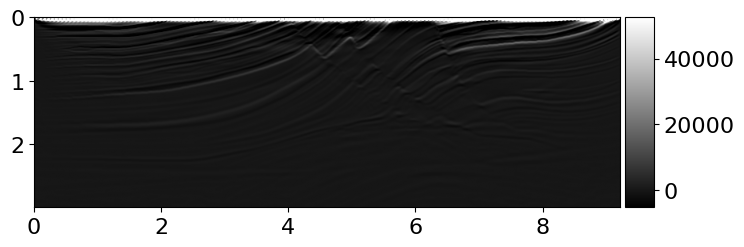

In [69]:
sliced_image_1 = data1.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image_1, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (738, 239)
Clipping low values below -2621.67896 and high values above 18021.05664.


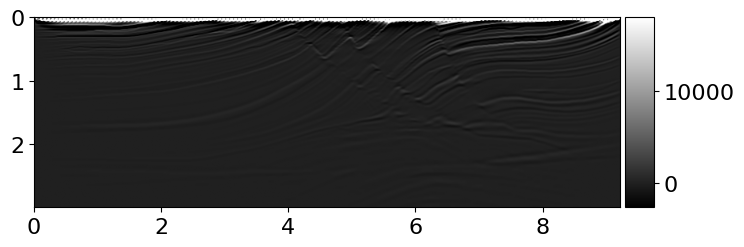

In [70]:
sliced_image_2 = data2.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image_2, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (738, 239)
Clipping low values below -4199.44385 and high values above 37401.38281.


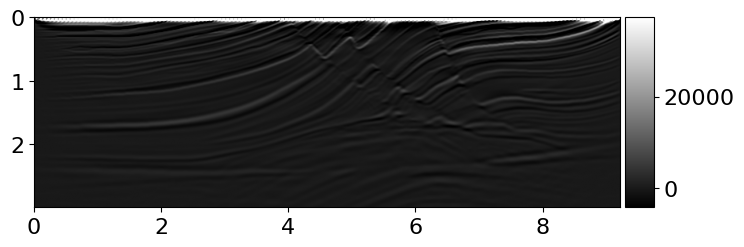

In [71]:
sliced_image_3 = data3.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image_3, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (738, 239)
Clipping low values below -2819.28931 and high values above 38984.14453.


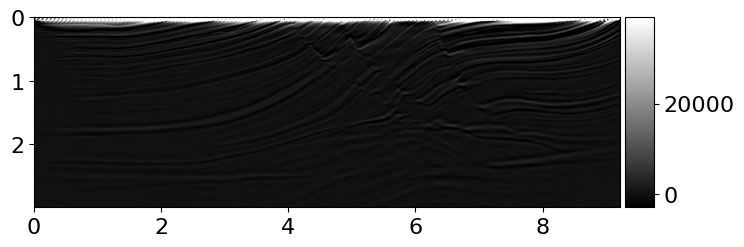

In [72]:
sliced_image_4 = data4.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image_4, axis=1),model,clip_percent=98,clip_low=2)


In [73]:
laplace_result_1 = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result_1, data1.laplace)
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000457, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [74]:
laplace_result_2 = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result_2, data1.laplace)
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000408, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [75]:
laplace_result_3 = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result_3, data1.laplace)
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000416, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [76]:
laplace_result_4 = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result_4, data1.laplace)
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000457, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Original data shape: (908, 410)
Clipping low values below -65.56931 and high values above 36.76799.


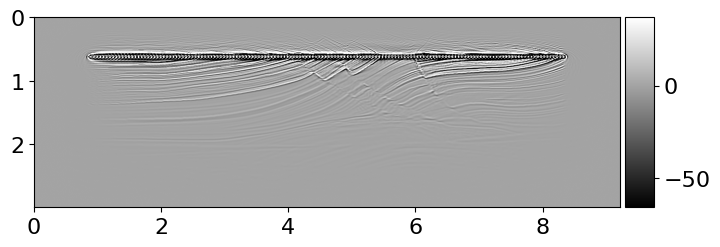

In [77]:
plot_image2(laplace_result_1.data,model,clip_percent=98,clip_low=2)


Original data shape: (908, 410)
Clipping low values below -65.56931 and high values above 36.76799.


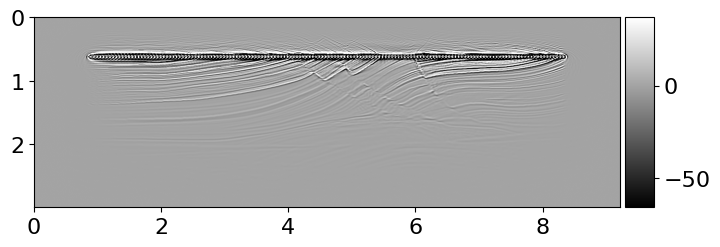

In [78]:
plot_image2(laplace_result_2.data,model,clip_percent=98,clip_low=2)


Original data shape: (908, 410)
Clipping low values below -65.56931 and high values above 36.76799.


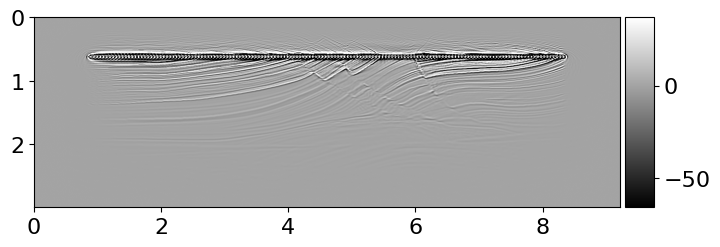

In [79]:
plot_image2(laplace_result_3.data,model,clip_percent=98,clip_low=2)


Original data shape: (908, 410)
Clipping low values below -65.56931 and high values above 36.76799.


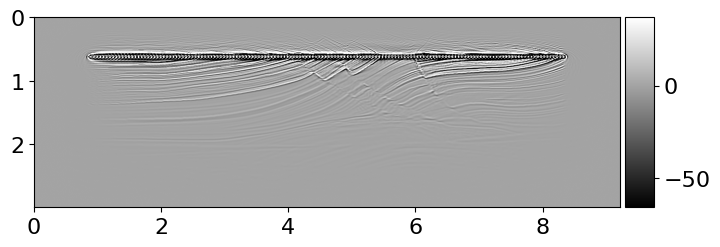

In [80]:
plot_image2(laplace_result_4.data,model,clip_percent=98,clip_low=2)


Original data shape: (738, 240)
Clipping low values below -97.52957 and high values above 38.77316.


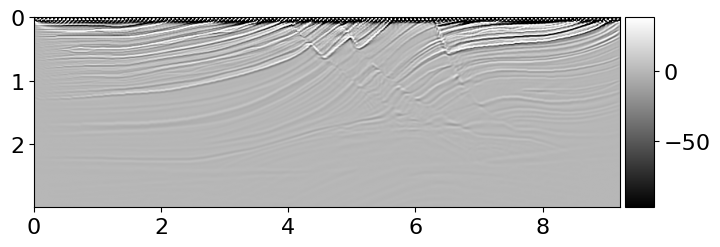

In [81]:
sliced_laplace_1 = laplace_result_1.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace_1,model,clip_percent=98,clip_low=2)


Original data shape: (738, 240)
Clipping low values below -97.52957 and high values above 38.77316.


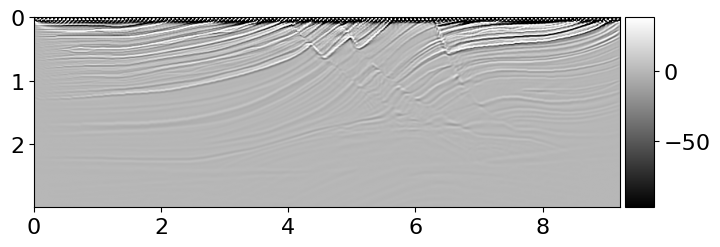

In [82]:
sliced_laplace_2 = laplace_result_2.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace_2,model,clip_percent=98,clip_low=2)


Original data shape: (738, 240)
Clipping low values below -97.52957 and high values above 38.77316.


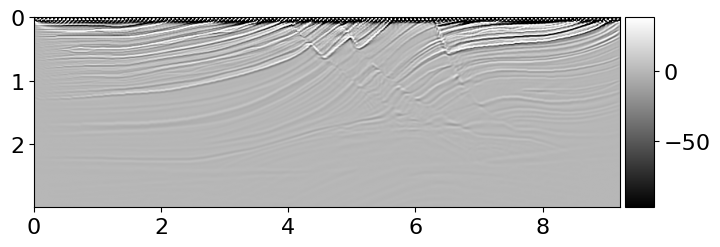

In [83]:
sliced_laplace_3 = laplace_result_3.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace_3,model,clip_percent=98,clip_low=2)


Original data shape: (738, 240)
Clipping low values below -97.52957 and high values above 38.77316.


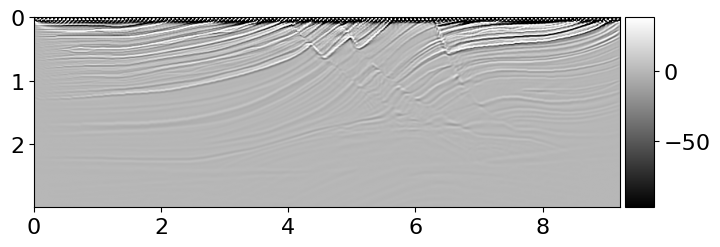

In [84]:
sliced_laplace_4 = laplace_result_4.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace_4,model,clip_percent=98,clip_low=2)


In [85]:
data1_lap = lapla (model, data1); data2_lap = lapla (model, data2)
data3_lap = lapla (model, data3); data4_lap = lapla (model, data4)

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [86]:
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
data1_lap.data[slices][:, :15] = 0; data2_lap.data[slices][:, :15] = 0; 
data3_lap.data[slices][:, :15] = 0; data4_lap.data[slices][:, :15] = 0

vmin1 = -35.; vmax1 = 35.

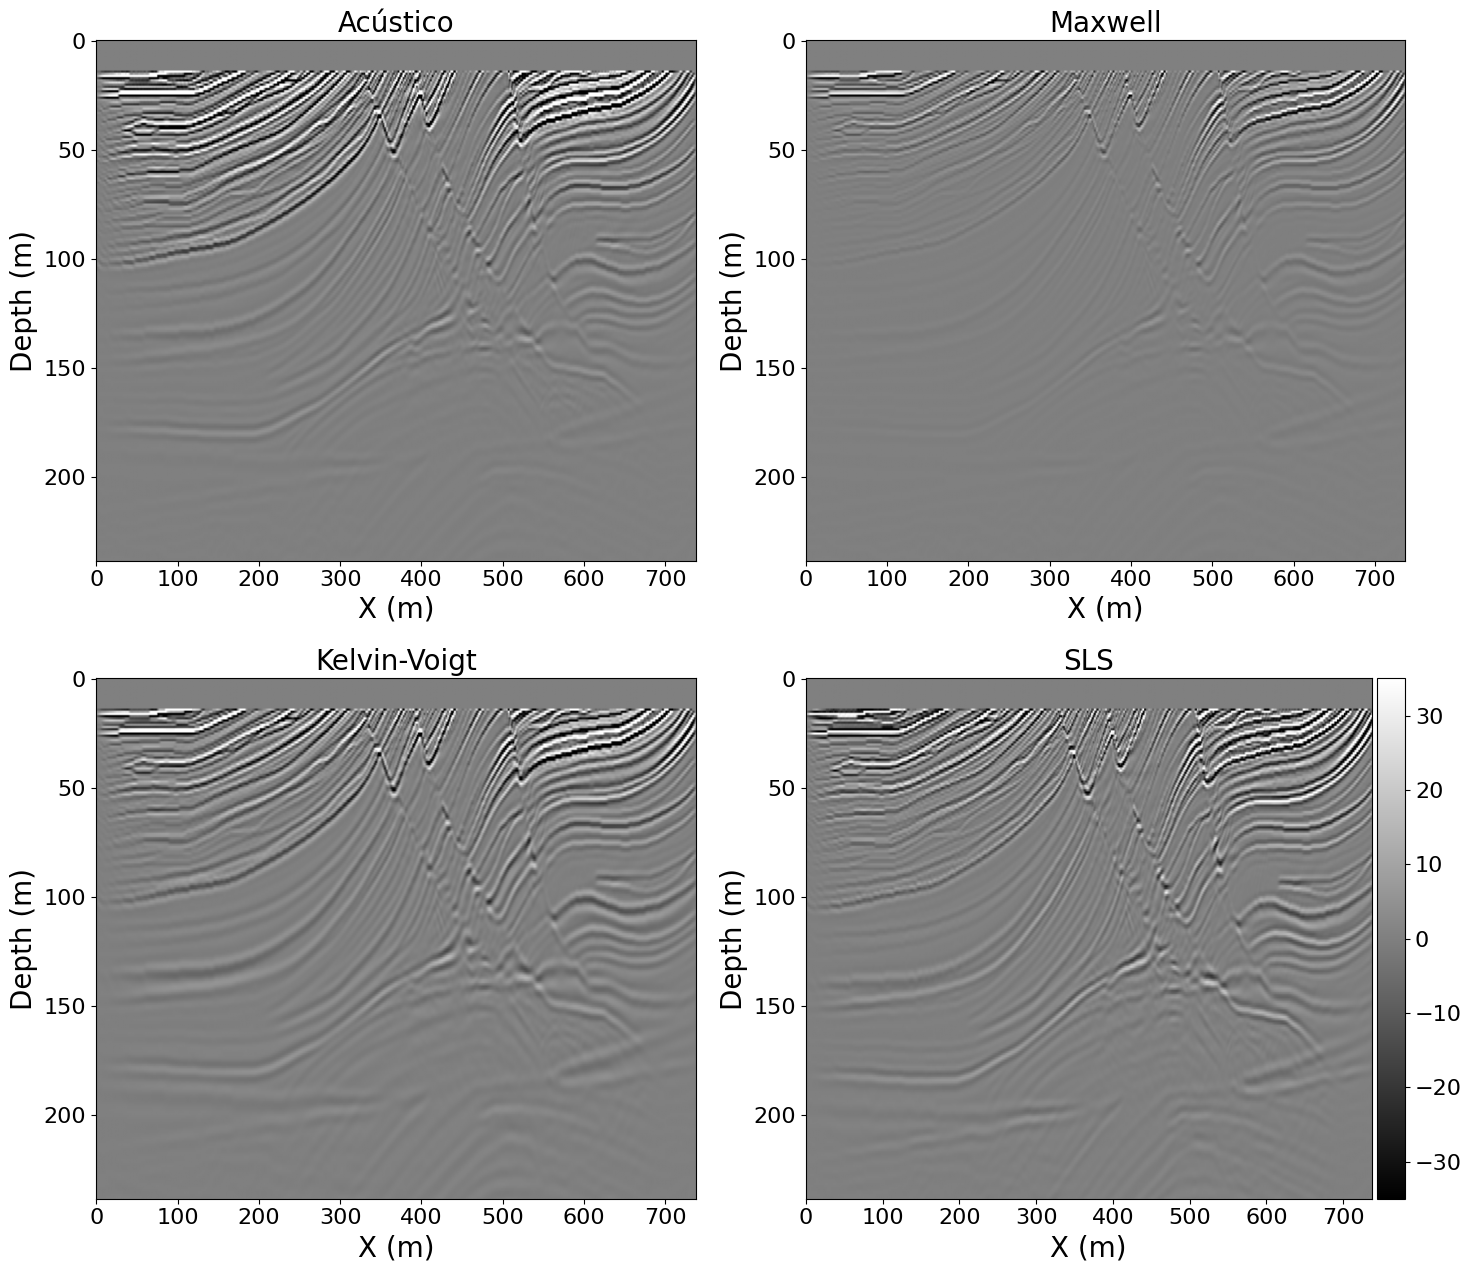

In [87]:
image_show(model, data1_lap, data2_lap, data3_lap, data4_lap, vmin1, vmax1)

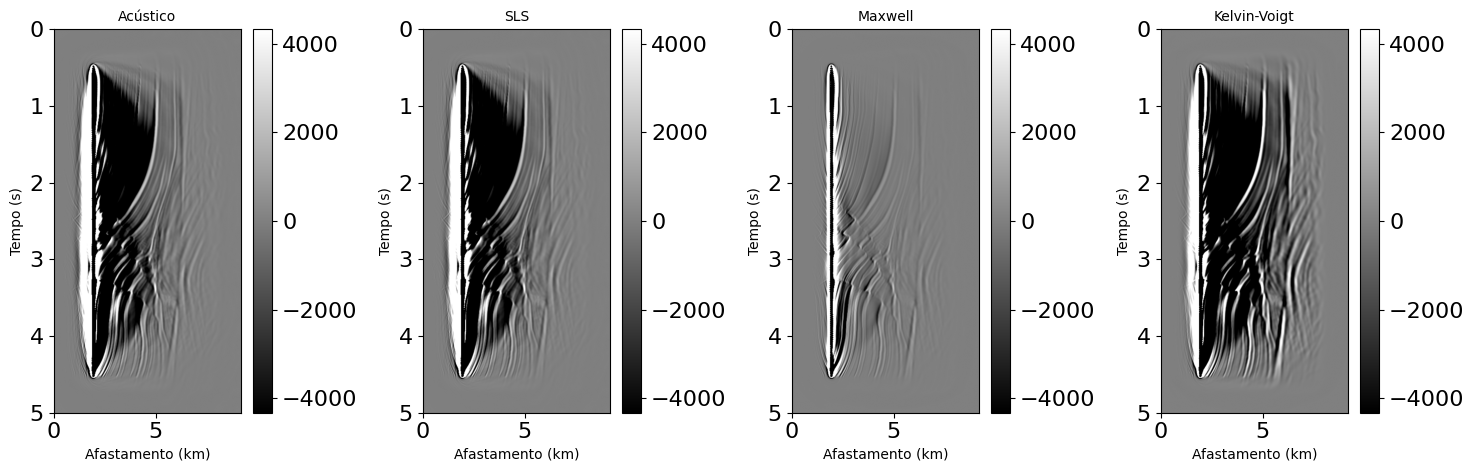

In [88]:
plot_shot(data1.data, data1.data, data2.data, data3.data, model, 0, tn, colorbar=True)